In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import linregress

## Data Exploration

In [2]:
# Load products-related dataset
file1 = 'raw/004_lomo_products_dataset.csv'
file2 = 'raw/005_lomo_product_category_name_translation.csv'
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Merge products dataset using 'product_category_name' as FK
# Before this I had manually updated the column name in 005 to 'product_category_name'
products_df = pd.merge(df1, df2, on='product_category_name', how='left')
products_df.drop(columns=['product_category_name'], inplace=True)

In [3]:
# Load order items dataset
file3 = 'raw/007_lomo_order_items_dataset.csv'
df3 = pd.read_csv(file3)

# Merge with order items dataset using 'product_id' as FK
orders_df = pd.merge(df3, products_df[['product_id', 'product_category_name_english']], 
                        on='product_id', how='left')

In [4]:
# Load orders dataset
file4 = 'raw/006_lomo_orders_dataset.csv'
df4 = pd.read_csv(file4)

# Merge with orders dataset using 'order_id' as FK
orders_df = pd.merge(orders_df, df4[['order_id','order_purchase_timestamp','customer_id']], 
                     on='order_id', how='left')

orders_df2 = orders_df.copy()
orders_df2.drop(columns=['order_id','order_item_id','product_id','seller_id',
                        'shipping_limit_date'], inplace=True)

In [20]:
# Ensure the purchase timestamp is in datetime format
orders_df2['order_purchase_timestamp'] = pd.to_datetime(orders_df2['order_purchase_timestamp'])

# Create a new column for total cost (price + freight_value)
orders_df2['total_cost'] = orders_df2['price'] + orders_df2['freight_value']

# Aggregate metrics for each product category
summary = orders_df2.groupby('product_category_name_english').agg(
    count=('order_purchase_timestamp', 'size'),
    total_rev=('price', 'sum'),
    total_cost=('total_cost', 'sum')
).reset_index()

print("Top 10 Product Categories by Total Revenue:")
print(summary.sort_values(by='total_rev', ascending=False).head(10))

print("\nTop 10 Product Categories by Total Qty Sold:")
print(summary.sort_values(by='count', ascending=False).head(10))

# Export the summary DataFrame to a CSV file
summary.to_csv('summary.csv', index=False)

Top 10 Product Categories by Total Revenue:
   product_category_name_english  count   total_rev  total_cost
43                 health_beauty   9670  1258681.34  1441248.07
70                 watches_gifts   5991  1205005.68  1305541.61
7                 bed_bath_table  11115  1036988.68  1241681.72
64                sports_leisure   8641   988048.97  1156656.48
14         computers_accessories   7827   911954.32  1059272.40
39               furniture_decor   8334   729762.49   902511.79
21                    cool_stuff   3796   635290.85   719329.95
49                    housewares   6964   632248.66   778397.77
5                           auto   4235   592720.11   685384.32
42                  garden_tools   4347   485256.46   584219.21

Top 10 Product Categories by Total Qty Sold:
   product_category_name_english  count   total_rev  total_cost
7                 bed_bath_table  11115  1036988.68  1241681.72
43                 health_beauty   9670  1258681.34  1441248.07
64            

In [6]:
# Create a column for month/year aggregation
orders_df2['order_month'] = orders_df2['order_purchase_timestamp'].dt.to_period('M').astype(str)

# Aggregate total product count by product category
category_counts = orders_df2.groupby('product_category_name_english').size().sort_values(ascending=False)
top_categories = category_counts.head(10).index

# Filter orders_df2 for only the top 10 product categories
filtered_orders = orders_df2[orders_df2['product_category_name_english'].isin(top_categories)]

# Aggregate monthly counts by product category for the top categories
monthly_trend = filtered_orders.groupby(['order_month', 'product_category_name_english']).size().reset_index(name='order_count')

# Calculate regression coeff for each top category
reg_coeff = []
for category in top_categories:
    category_data = monthly_trend[monthly_trend['product_category_name_english'] == category].copy()
    category_data['order_month_dt'] = pd.to_datetime(category_data['order_month'], format='%Y-%m')
    category_data['month_numeric'] = category_data['order_month_dt'].map(pd.Timestamp.toordinal)
    slope = linregress(category_data['month_numeric'], category_data['order_count'])[0]

    reg_coeff.append({
        'product_category_name_english': category,
        'regression_coefficient': slope
    })

trend_df = pd.DataFrame(reg_coeff).sort_values(by='regression_coefficient', ascending=False)

print("Regression Coefficients for the Top 10 Product Categories:")
print(trend_df.to_string(index=False))

Regression Coefficients for the Top 10 Product Categories:
product_category_name_english  regression_coefficient
                health_beauty                1.297328
               bed_bath_table                1.145708
                watches_gifts                0.915610
                   housewares                0.873153
        computers_accessories                0.870392
               sports_leisure                0.814967
              furniture_decor                0.693733
                         auto                0.583927
                    telephony                0.418335
                 garden_tools                0.312076


In [22]:
monthly_trend.to_csv('product_category_monthly_trend.csv', index=False)

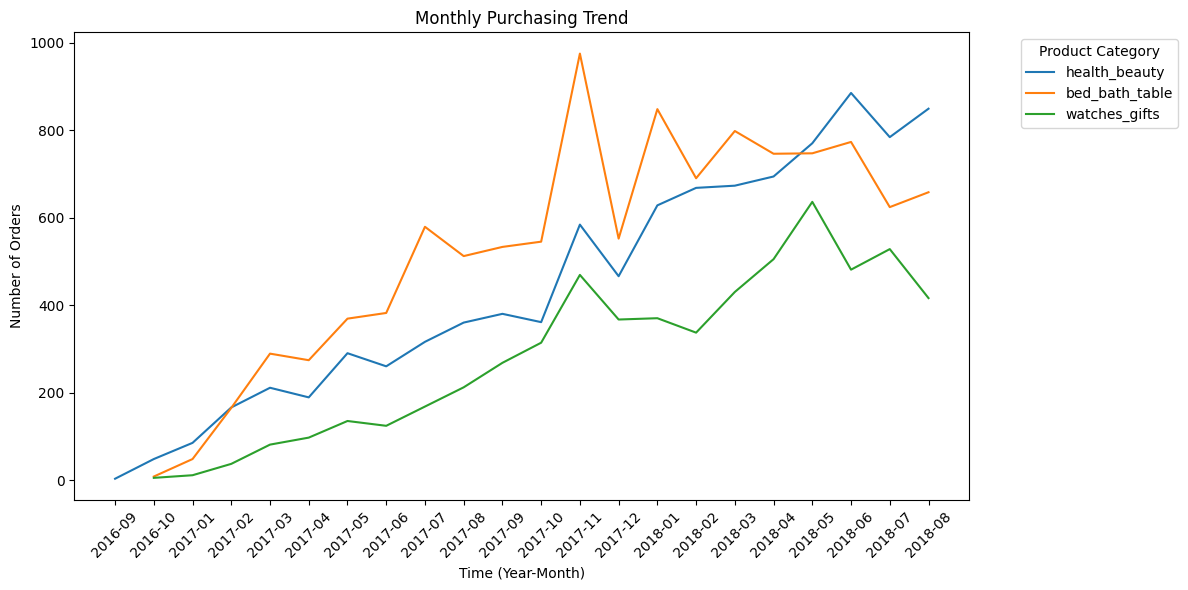

In [7]:
# Plot the monthly purchasing trend for the top 3 categories
categories_to_plot = ['health_beauty', 'bed_bath_table', 'watches_gifts']
filtered_trend = monthly_trend[monthly_trend['product_category_name_english'].isin(categories_to_plot)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_trend, x='order_month', y='order_count', hue='product_category_name_english')
plt.title('Monthly Purchasing Trend')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
# Combine customers and orders datasets
customers_df = pd.read_csv('raw/001_lomo_customers_dataset.csv')

orders_customers_df = pd.merge(orders_df, customers_df[['customer_id', 'customer_state']],
                               on='customer_id', how='inner')

In [ ]:
# Group by state and category
summary_by_state = orders_customers_df.groupby(['customer_state', 'product_category_name_english']).size().reset_index(name='count')

# For each state, pick the row with the highest count
top_category_by_state = summary_by_state.loc[summary_by_state.groupby('customer_state')['count'].idxmax()]

# Count how many times each category appears as the top category
category_counts = top_category_by_state['product_category_name_english'].value_counts().reset_index(name='times_top')
category_counts.rename(columns={'index': 'product_category_name_english'}, inplace=True)

# Sort by the times a category appears as top
category_counts.sort_values(by='times_top', ascending=False, inplace=True)

print(category_counts)


  product_category_name_english  times_top
0                bed_bath_table         46
1                 health_beauty         11
2               furniture_decor          7
3         computers_accessories          2
4                sports_leisure          2
5                 watches_gifts          1


In [23]:
category_counts.to_csv('top_category_by_state.csv', index=False)

In [17]:
# Create df containing only data on top categories in each state
unique_states = orders_customers_df['customer_state'].unique()
unique_states_df = pd.DataFrame({
    'State': unique_states,
    'Country': ['Thailand'] * len(unique_states)
})

merged_df = pd.merge(
    unique_states_df,
    summary_by_state,
    left_on='State', 
    right_on='customer_state', 
    how='inner'
)

# Keep only the row with the highest count for each state, drop customer_state
merged_top_df = merged_df.loc[merged_df.groupby('State')['count'].idxmax()]
merged_top_df.drop(columns=['customer_state'], inplace=True)

In [19]:
# Combine with latlong data and export
latlong_df = pd.read_excel('latlong.xlsx')
geo_df = pd.merge(merged_top_df, latlong_df[['State','Lat','Long']], on='State', how='inner')
geo_df.to_excel('geo_df.xlsx', index=False)

## Descriptive Analysis

In [ ]:
# Calculate metrics by state: total orders, total revenue and average order value
state_metrics = orders_customers_df.groupby('customer_state').agg({
    'order_id': 'nunique',
    'price': 'sum'
}).rename(columns={'order_id': 'num_orders', 'price': 'total_revenue'})

state_metrics['avg_order_value'] = state_metrics['total_revenue'] / state_metrics['num_orders']
print("State-wise Descriptive Metrics:")
print(state_metrics.sort_values(by='total_revenue', ascending=False))

State-wise Descriptive Metrics:
                   num_orders  total_revenue  avg_order_value
customer_state                                               
Roi Et                   6140      866737.41       141.162445
Nakhon Ratchasima        5511      755149.76       137.025905
Sakon Nakhon             4977      682149.44       137.060366
Si Sa Ket                4773      654661.81       137.159399
Maha Sarakham            4133      563475.13       136.335623
...                       ...            ...              ...
Surat Thani               278       35502.18       127.705683
Phuket                    240       33334.33       138.893042
Ang Thong                 205       27609.65       134.681220
Chai Nat                  142       15901.60       111.983099
Yala                       76        9258.62       121.823947

[69 rows x 3 columns]


In [25]:
state_metrics.describe()

,num_orders,total_revenue,avg_order_value
count,69.000000,69.000000,69.000000
mean,1429.942029,196980.343478,137.110870
std,1444.484631,198974.458365,8.440521
min,76.000000,9258.620000,111.983099
25%,398.000000,54473.660000,132.331001
50%,874.000000,117197.710000,136.335623
75%,1908.000000,268554.030000,141.152650
max,6140.000000,866737.410000,159.471066


In [24]:
state_metrics.to_csv('state_metrics.csv')

In [13]:
# Ensure the purchase timestamp is in datetime format
orders_customers_df['order_purchase_timestamp'] = pd.to_datetime(orders_customers_df['order_purchase_timestamp'])

# Set a snapshot date (one day after the lastest purchase)
snapshot_date = orders_customers_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = orders_customers_df.groupby('customer_id').agg({
    'order_purchase_timestamp': 'max',
    'order_id': 'count',
    'price': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'LastPurchase', 'Frequency', 'Monetary']
rfm['Recency'] = (snapshot_date - pd.to_datetime(rfm['LastPurchase'])).dt.days
rfm = pd.merge(rfm, customers_df[['customer_id', 'customer_state']], on='customer_id', how='left')

# Aggregate RFM metrics by state
rfm_state = rfm.groupby('customer_state').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'Recency': 'AvgRecency', 'Frequency': 'AvgFrequency', 'Monetary': 'AvgMonetary'})

rfm_state_sorted = rfm_state.sort_values(by=['AvgMonetary', 'AvgFrequency', 'AvgRecency'], ascending=[False, False, True])

print("\nRFM Metrics by State:")
print(rfm_state_sorted)

C:\Users\trust\AppData\Local\Temp\ipykernel_6428\3525210548.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  orders_customers_df['order_purchase_timestamp'] = pd.to_datetime(orders_customers_df['order_purchase_timestamp'])



RFM Metrics by State:
                AvgRecency  AvgFrequency  AvgMonetary
customer_state                                       
Pathum Thani    241.853026      1.138329   159.471066
Loei            249.728070      1.178363   159.279708
Sukhothai       229.160563      1.138028   159.226000
Tak             259.334342      1.118003   153.719788
Rayong          250.692208      1.161039   152.204818
...                    ...           ...          ...
Ranong          242.510460      1.144351   126.404017
Phangnga        249.545455      1.118881   126.387028
Trang           236.479021      1.150350   124.641643
Yala            235.513158      1.065789   121.823947
Chai Nat        244.239437      1.140845   111.983099

[69 rows x 3 columns]


## Regression Analysis

In [14]:
orders_customers_df['order_purchase_timestamp'] = pd.to_datetime(orders_customers_df['order_purchase_timestamp'])
orders_customers_df['order_month'] = orders_customers_df['order_purchase_timestamp'].dt.to_period('M').astype(str)

monthly_state = orders_customers_df.groupby(['order_month', 'customer_state']).agg(
    order_count=('order_id', 'nunique'),
    total_revenue=('price', 'sum')
).reset_index()

# Convert order_month to a numeric value
monthly_state['order_month_dt'] = pd.to_datetime(monthly_state['order_month'], format='%Y-%m')
monthly_state['month_numeric'] = monthly_state['order_month_dt'].map(pd.Timestamp.toordinal)

# Run regression: order count ~ time + state
model = smf.ols("order_count ~ month_numeric + C(customer_state)", data=monthly_state).fit()
print("\nRegression Model Summary (Impact of time and state on order count):")
print(model.summary())


Regression Model Summary (Impact of time and state on order count):
                            OLS Regression Results                            
Dep. Variable:            order_count   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     80.93
Date:                Wed, 05 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:56:24   Log-Likelihood:                -7217.2
No. Observations:                1439   AIC:                         1.457e+04
Df Residuals:                    1369   BIC:                         1.494e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

In [15]:
# Sort the coefficients by value
coefficients_df = model.params.to_frame(name="coefficient").reset_index()
coefficients_df.rename(columns={"index": "term"}, inplace=True)
coefficients_df.sort_values("coefficient", ascending=False, inplace=True)

print(coefficients_df.head(5))

                                      term  coefficient
45             C(customer_state)[T.Roi Et]   201.523810
26  C(customer_state)[T.Nakhon Ratchasima]   171.571429
47       C(customer_state)[T.Sakon Nakhon]   138.144887
53          C(customer_state)[T.Si Sa Ket]   123.704882
21      C(customer_state)[T.Maha Sarakham]   105.952381
